In [66]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os

# Step 1: Download dataset using kagglehub
path = kagglehub.dataset_download("bhavikjikadara/car-price-prediction-dataset")
print("Path to dataset files:", path)

# Print the contents of the path
print("\nContents of the downloaded dataset path:")
for item in os.listdir(path):
    print(item)

# Load the dataset
file_path = f"{path}/car_prediction_data.csv"  # Adjust path if necessary
df = pd.read_csv(file_path)

Path to dataset files: /root/.cache/kagglehub/datasets/bhavikjikadara/car-price-prediction-dataset/versions/1

Contents of the downloaded dataset path:
car_prediction_data.csv


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB
None

Summary Statistics:
              Year  Selling_Price  Present_Price     Kms_Driven       Owner
count   301.000000     301.000000     301.000000     301.000000  301.000000
mean   2013.627907       4.661296       7.628472   36947.205980    0.043189
std       2.891554       5.082812       8.644115   38886.883882    0.247915
min  

<Figure size 1000x600 with 0 Axes>

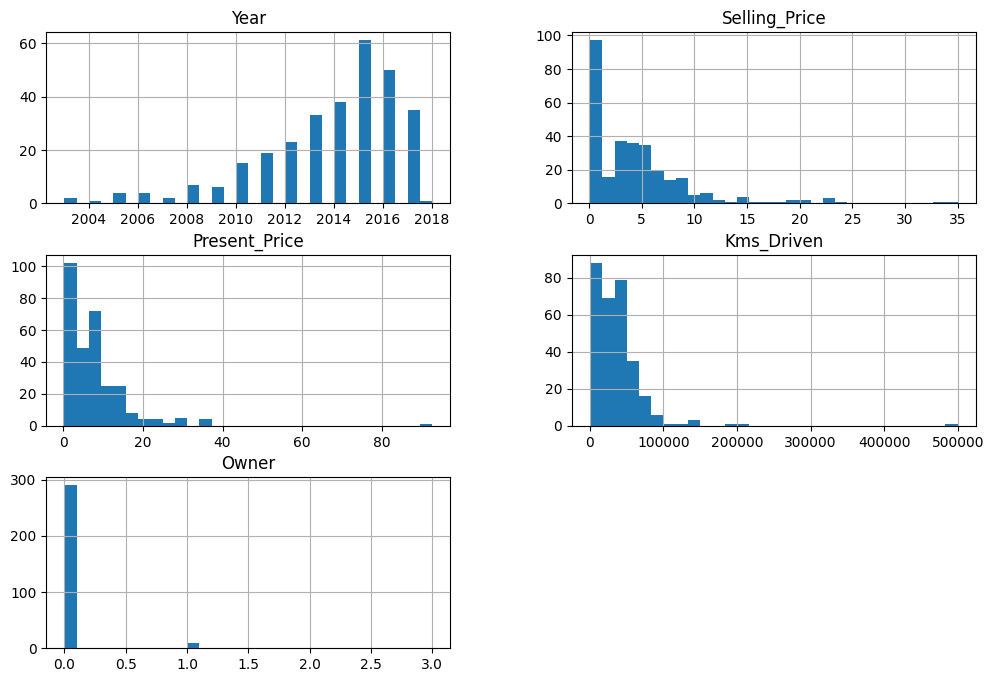

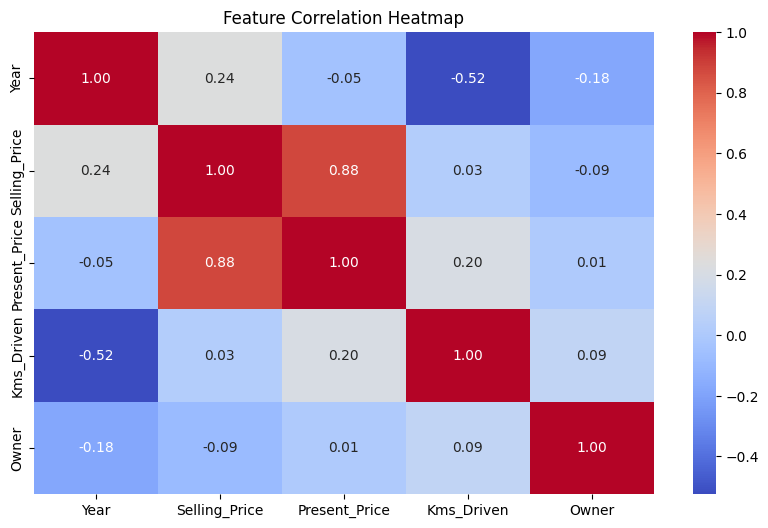

In [67]:
# Step 2: Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize distributions of numerical columns
plt.figure(figsize=(10, 6))
df.hist(figsize=(12, 8), bins=30)
plt.show()

numeric_features = df.select_dtypes(include=[np.number]).columns
# Visualize correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [68]:
# Step 3: Data Preprocessing
# No Missing Values
# Encode categorical variables (example: car make, model)
df = pd.get_dummies(df, drop_first=True)

In [69]:
# Step 4: Splitting data into features and target variable
X = df.drop(columns=['Selling_Price'])  # 'price' is the target column, adjust as per your dataset
y = df['Selling_Price']

# Save the training columns for use in the API
training_columns = list(X.columns)
joblib.dump(training_columns, 'training_columns.pkl')
print("Training columns saved as 'training_columns.pkl'")
print("Expected input after preprocessing:", training_columns)

Training columns saved as 'training_columns.pkl'
Expected input after preprocessing: ['Year', 'Present_Price', 'Kms_Driven', 'Owner', 'Car_Name_Activa 3g', 'Car_Name_Activa 4g', 'Car_Name_Bajaj  ct 100', 'Car_Name_Bajaj Avenger 150', 'Car_Name_Bajaj Avenger 150 street', 'Car_Name_Bajaj Avenger 220', 'Car_Name_Bajaj Avenger 220 dtsi', 'Car_Name_Bajaj Avenger Street 220', 'Car_Name_Bajaj Discover 100', 'Car_Name_Bajaj Discover 125', 'Car_Name_Bajaj Dominar 400', 'Car_Name_Bajaj Pulsar  NS 200', 'Car_Name_Bajaj Pulsar 135 LS', 'Car_Name_Bajaj Pulsar 150', 'Car_Name_Bajaj Pulsar 220 F', 'Car_Name_Bajaj Pulsar NS 200', 'Car_Name_Bajaj Pulsar RS200', 'Car_Name_Hero  CBZ Xtreme', 'Car_Name_Hero  Ignitor Disc', 'Car_Name_Hero Extreme', 'Car_Name_Hero Glamour', 'Car_Name_Hero Honda CBZ extreme', 'Car_Name_Hero Honda Passion Pro', 'Car_Name_Hero Hunk', 'Car_Name_Hero Passion Pro', 'Car_Name_Hero Passion X pro', 'Car_Name_Hero Splender Plus', 'Car_Name_Hero Splender iSmart', 'Car_Name_Hero Super 

In [70]:
# Step 5: Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [71]:
# Step 6: Feature Scaling (Normalization/Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in the API
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [72]:
# Step 7: Model Building (Random Forest Regression)
from sklearn.model_selection import GridSearchCV

# Step 1: Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Step 2: Set up the GridSearchCV with RandomForestRegressor
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2,
                           scoring='neg_mean_absolute_error')  # Use negative MAE for minimization

# Step 3: Fit the GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Step 4: Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation MAE:", -grid_search.best_score_)

# Step 5: Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation MAE: 0.9246567721051576


Mean Absolute Error: 0.6485222261434215
Mean Squared Error: 1.1631980415685375
Root Mean Squared Error: 1.0785165930891085
R² Score: 0.9610252403605812


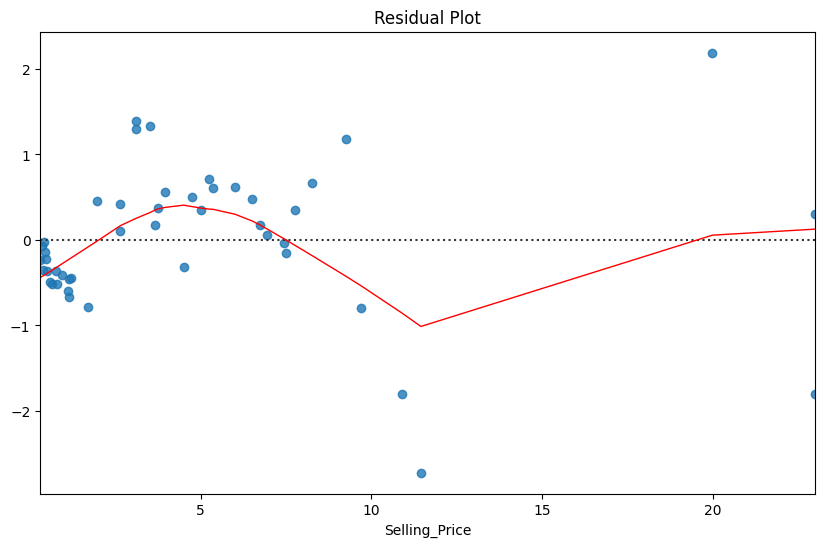

In [73]:
# Step 8: Model Evaluation
y_pred = best_model.predict(X_test_scaled)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

# Visualize residuals
plt.figure(figsize=(10, 6))
sns.residplot(x=y_test, y=y_pred, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residual Plot')
plt.show()

In [74]:
# Step 9: Save the trained model using joblib
joblib.dump(best_model, 'car_price_model.pkl')
print("Model saved successfully as 'car_price_model.pkl'")

Model saved successfully as 'car_price_model.pkl'
